# Measuring Access to Healthcare in the IE

### Software

To do a full-statck assessment of accessibility we need to link together a few diferent pieces of software:

- [`urbanaccess`]() builds a routable, multimodal transportation network. It consumes data from (1) OpenStreetMap and (2) GTFS and combines them into a network whose distance between nodes is measured in travel time
- [`pandana`]() finds the shortest path through the network between all pairs of nodes using fast underlying C++ library, and can optionally create distance-weighted sums of resources--a simple measurre of accessibility that accounts for space but not competition. `pandana` consumes (1) the network generated by `urbanaccess` and (2) a set of oigins and (3) destinations. We will use `pandana` to create the shortest-path travel cost matrix relating origins to destinations
- [`access`]() creates measures of accessibility that account for distance traveled and include various weighting schemes to discount for competition. `accesss` consumes geodataframes representing (1) supply and (2) demand, and (3) a travel cost matrix. In our case, (1) is equivalent to the desitnation set above, (2) is a set of population counts, and (3) is the output from `pandana`

### Data

- OSM
    - urbanaccess (and osmnet) have the ability to download data from OSM in the format they need using a function called `network_from_bbox` which is nice, but can be very time consuming depending on the size of the network
    - I have stored pre-built metropolitan scale networks (extending 8km beyond the metro border, so supporting queries up to that range) in [our quilt bucket](https://open.quiltdata.com/b/spatial-ucr/packages/osm/metro_networks_8k)
- GTFS
    - [transitfeeds](https://transitfeeds.com/p/riverside-transit-agency/531) is a good place to get up-to-date gtfs data, but it can be hard to ensure you've included every relevant transit agency serving the study area (and impossible to know whether there's another agency that hasnt yet posted its data there)

In [ ]:
import quilt3
import pandas as pd
import numpy as np
import geopandas as gpd
import urbanaccess as ua
import access
import pandana as pdna
from geosnap import Community
from osmnx import pois
from access import access
from access import weights as acweights

In [ ]:
pdna.__version__

If you get "ImportError: cannot import name 'vincenty' from 'geopy.distance'" you need to downgrade geopy to version 1.9, e.g.

```
pip install geopy==1.9
```

(I sent [a fix](https://github.com/UDST/osmnet/pull/21) that thas been merged, but still waiting on a new release of the `osmnet` package)

#### Creating a multimodal network

download OSM data from our quilt bucket

In [3]:
p = quilt3.Package.browse("osm/metro_networks_8k", "s3://spatial-ucr")

Loading manifest: 100%|██████████| 390/390 [00:00<00:00, 12034.07entries/s]


In [4]:
p['40140.h5'].fetch(dest="../data/")

100%|██████████| 42.1M/42.1M [00:05<00:00, 7.70MB/s]


PackageEntry('file:///home/knaaptime/projects/healthacc/data/')

In [2]:
# read in the pre-saved OSM network using pandana

osm_network = pdna.Network.from_hdf5("../data/40140.h5")

We convert to an urbanaccess network so we have travel times instead of distances

In [3]:
ua_osm = ua.create_osm_net(osm_edges=osm_network.edges_df,
                              osm_nodes=osm_network.nodes_df,
                              travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.01 seconds


In [4]:
ua_osm = pdna.Network(ua_osm.osm_nodes["x"],
                               ua_osm.osm_nodes["y"],
                               ua_osm.osm_edges["from"],
                               ua_osm.osm_edges["to"],
                               ua_osm.osm_edges[["weight"]],
                               twoway=False)

We can use geosnap to quickly grab data for the IE region

In [ ]:
socal = Community.from_census(msa_fips='40140', years=[2010])

In [ ]:
socal = socal.gdf

And we can use `osmnx` to quickly get poi data related to healthcare locations from openstreetmap

In [ ]:
health = pois.pois_from_polygon(socal.unary_union, tags={'amenity':['doctor', 'hospital']})

In [ ]:
health.plot()

In [ ]:
health['care'] = 1

This function uses the shortest path functionality in pandana to calculate
the quickest walking path between every paid of tracts in the IE region

In [ ]:
def compute_travel_cost_matrix(origins, destinations, network, reindex_name=False, square=False):
    origins = origins.copy()
    destinations = destinations.copy()
    
    origins['osm_ids'] = network.get_node_ids(origins.centroid.x, origins.centroid.y).astype(int)
    destinations['osm_ids'] = network.get_node_ids(destinations.centroid.x, destinations.centroid.y).astype(int)

    combined = origins.osm_ids.copy().append(destinations.osm_ids.copy()) 
    cost = network.shortest_path_lengths(combined, combined[::-1])

    
    df = pd.DataFrame()
    
            
    if reindex_name:
        newids = origins[reindex_name].copy().append(destinations[reindex_name].copy())
        df['origin'] = newids.values
        df['destination'] = newids[::-1].values
    
    else:
        df['origin'] = combined.values
        df['destination'] = combined[::-1].values
    
   
    df['cost'] = cost
    
    if square:
        df = df[:len(origins)]
    return df

In [115]:
tract_cost = compute_travel_cost_matrix(socal, socal, ua_osm, reindex_name='geoid')

/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """
/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [116]:
tract_cost

,origin,destination,cost
0,06071009112,06065044804,4294967.295
1,06071009713,06071008500,4294967.295
2,06071009800,06071006700,4294967.295
3,06071009912,06065043309,4294967.295
4,06071010016,06065042738,4294967.295
...,...,...,...
817,06065042738,06071010016,4294967.295
818,06065043309,06071009912,4294967.295
819,06071006700,06071009800,4294967.295
820,06071008500,06071009713,1552.189


In [78]:
joined  = gpd.sjoin(socal, health[['geometry', 'care']], op='intersects', how='left').groupby('geoid').sum()['care']

/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


In [138]:
socal = socal.merge(joined, left_on='geoid', right_index=True)

In [140]:
ac = access(demand_df = socal,
                              demand_index = 'geoid',
                              demand_value = 'n_total_pop',
                              supply_df    = socal,
                              supply_index = 'geoid',
            cost_df=tract_cost,
            cost_origin='origin',
            cost_dest='destination',
            cost_name='cost',
            supply_value='care_y'
      )

In [118]:
gravity = acweights.gravity(scale = 60, alpha = -1)
gaussian = acweights.gaussian(20)

In [160]:
ac.raam(name = "raam", tau = 60);
ac.two_stage_fca(name = "2sfca", max_cost = 60,)
ac.enhanced_two_stage_fca(name = "g2sfca", weight_fn = gaussian)
ac.three_stage_fca(name = "3sfca")
ac.weighted_catchment(name = "gauss", weight_fn = gaussian)
ac.weighted_catchment(name = "gravity", weight_fn = gravity)
ac.score

access INFO     :: Overwriting 2sfca_care_y.


,3sfca_care_y
geoid,
06065030101,0.0
06065030103,0.0
06065030104,0.0
06065030200,0.0
06065030300,0.0
...,...
06071025000,0.0
06071025100,0.0
06071940100,0.0


In [163]:
results = socal[['geoid', 'geometry']].merge(ac.access_df, left_on='geoid', right_index=True)

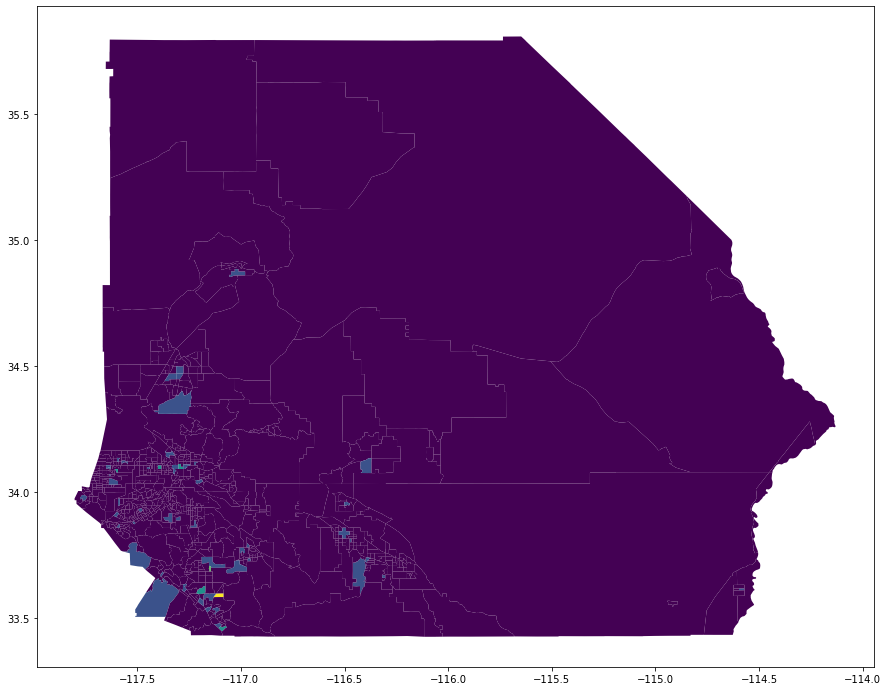

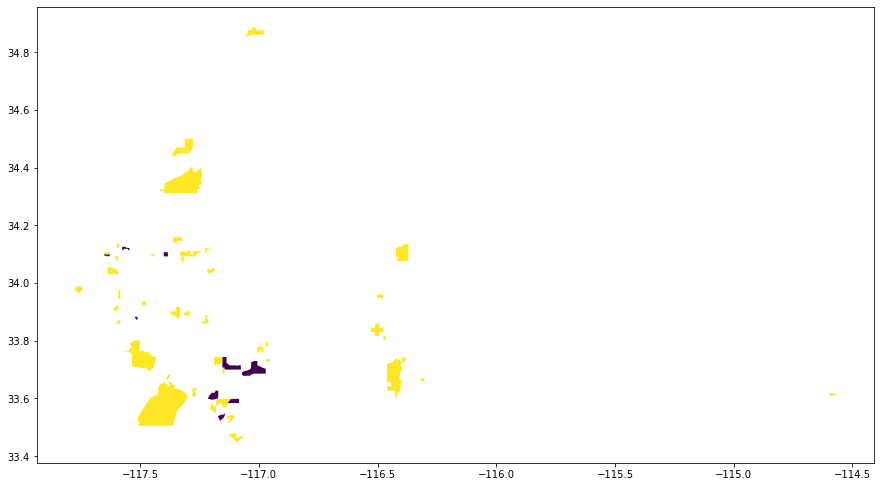

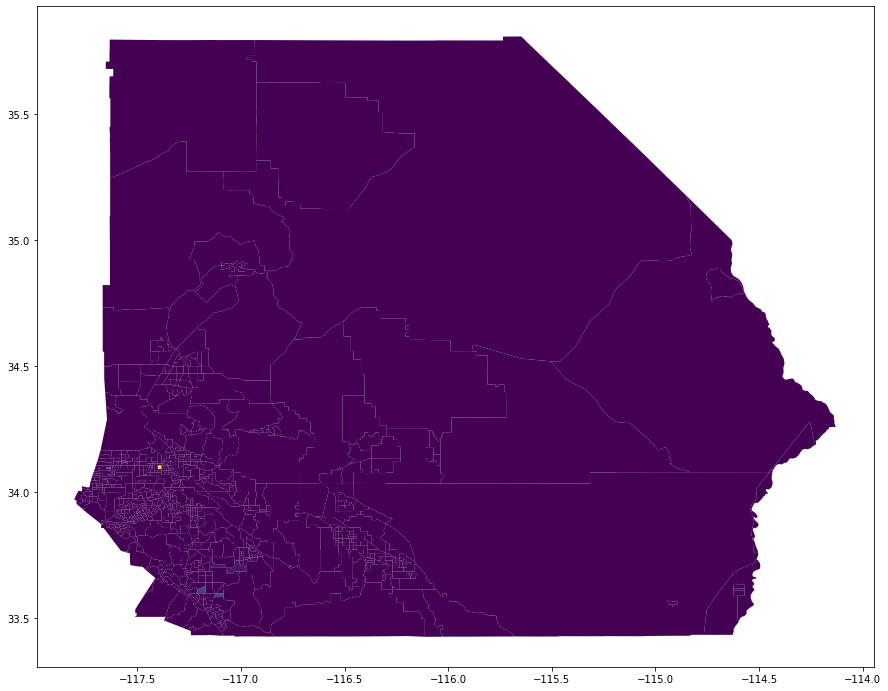

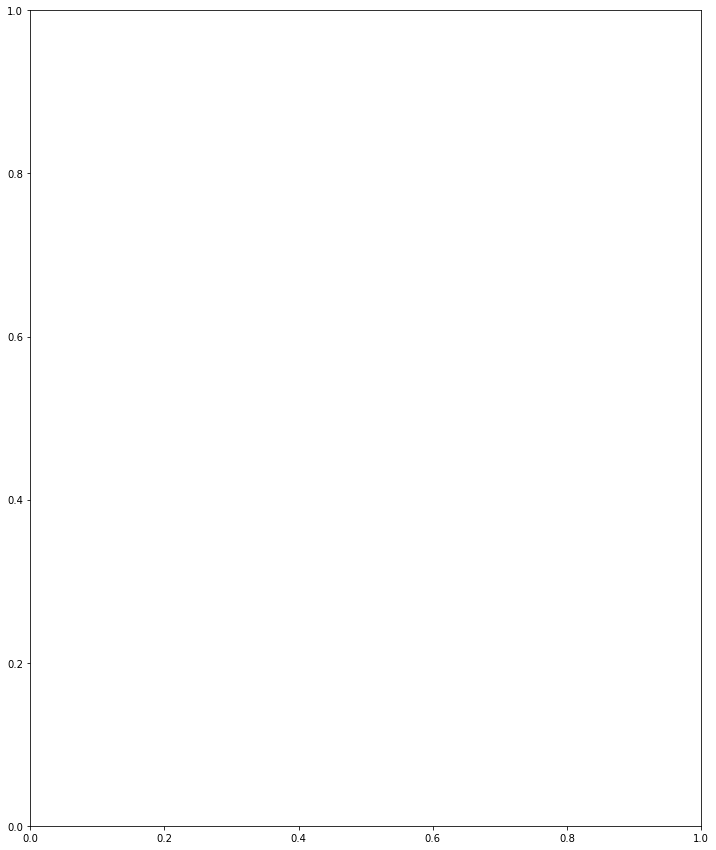

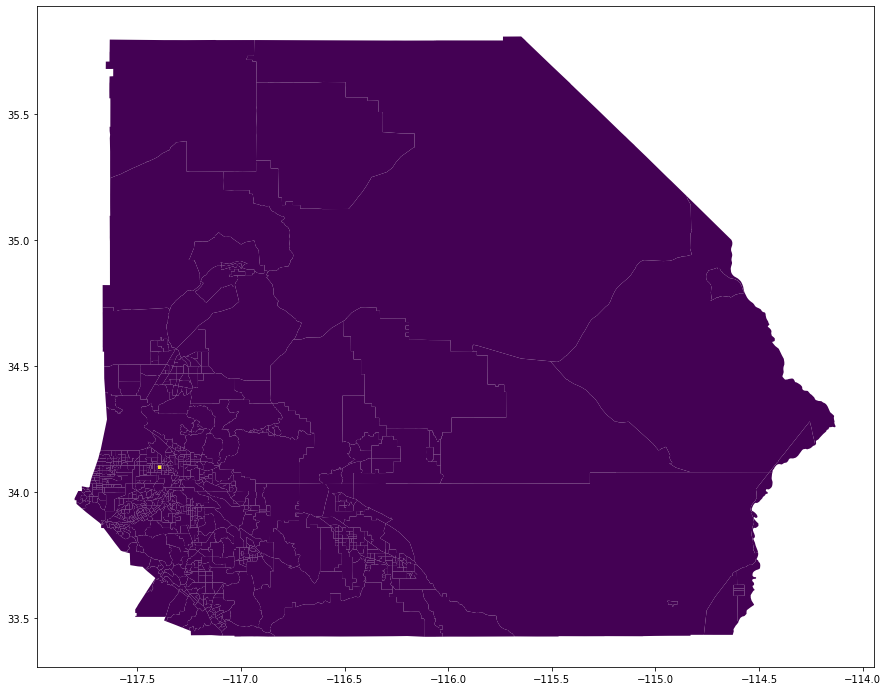

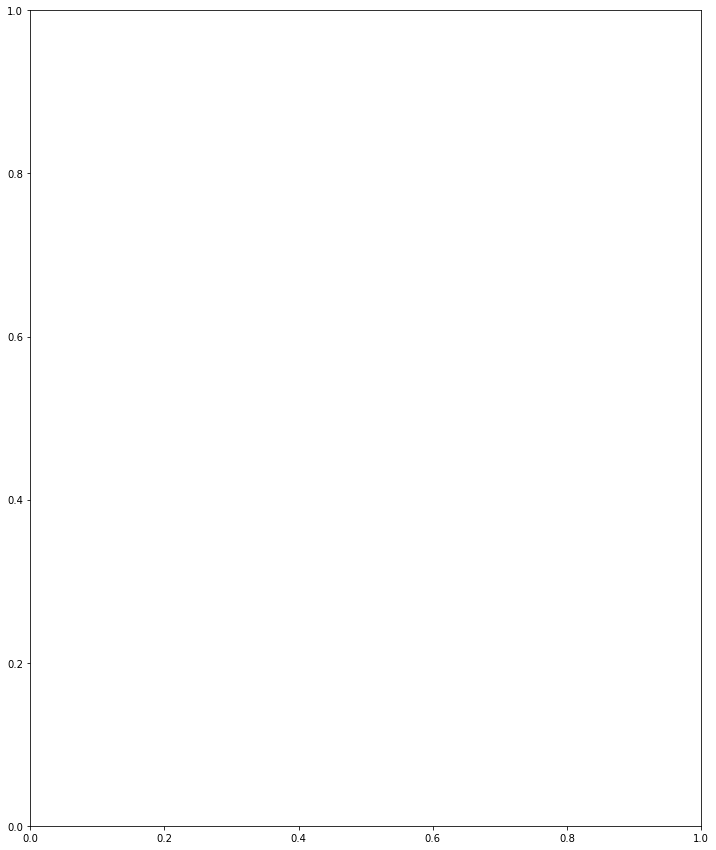

In [168]:
for i in ['grav_care_y', 'raam_care_y', 'gravity_care_y', '2sfca_care_y', 
         'g2sfca_care_y', '3sfca_care_y']:
    results.plot(column=i, scheme='quantiles', k=8, figsize=(15,15))

<AxesSubplot:>

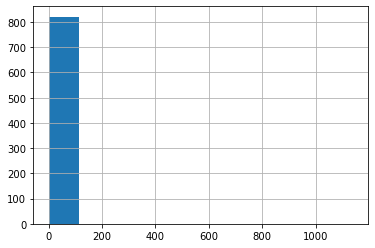

In [172]:
results['g2sfca_care_y'].hist()

<AxesSubplot:>

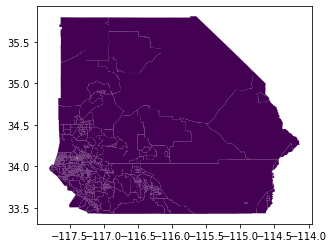

In [173]:
results.plot('g2sfca_care_y')